In [2]:
import os
import sys
import torch
from torch import Tensor
import torch.testing as torch_testing
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import numpy.testing as npt
from functools import reduce
import matplotlib.pyplot as plt
import os
import pickle
import cv2
from dataclasses import dataclass
import tqdm
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_device(device)

`convolutional layer`: main building block. Contains a set of learnable filters.

`forward pass`: each filter is slided over the spatial dimensions of the input volume

Hyperparameters:
- `F`: filter size
- `P`: padding amount
- `S`: stride/step
- `k`: number of filters: should match the depth of the input volume

From shape ($H_i$, $W_i$, $D$) to shape ($H_o$, $W_o$, $k$), where:

\begin{equation}
W_o = \frac{W_i - F + 2P}{S} + 1
\end{equation}

\begin{equation}
H_o = \frac{H_i - F + 2P}{S} + 1
\end{equation}

<img src="https://lh6.googleusercontent.com/gZxwFH6mQ5tPjz6LzVbOaNeVuR1NC-BnuemIWO41qnn7r1PvP4qzwXRWC1OJgo2_PD08qaqJ2-VCF3q9laeK885IJwK-dHhpLDkvRZrx4vxrbLDTsKD2iZYM5SFRq4A6XTklk7_h" style="width:50vw;display:block;transform: translateX(10vw)"/>

Text(0.5, 1.0, 'Zero Padded - 2')

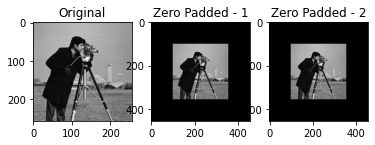

In [41]:
def zero_pad(X, pad):
    X = np.pad(X, pad_width=[(0,0),(pad, pad),(pad, pad)], mode='constant')
    return X

img = np.asarray(cv2.imread('cameraman.jpg', cv2.IMREAD_GRAYSCALE))
image_1, image_2 = zero_pad(np.array([img, img]), 100)

plt.subplot(1, 3, 1).imshow(img, cmap='gray')
plt.title('Original')
plt.subplot(1, 3, 2).imshow(image_1, cmap='gray')
plt.title('Zero Padded - 1')
plt.subplot(1, 3, 3).imshow(image_2, cmap='gray')
plt.title('Zero Padded - 2')